In [230]:
import tensorflow as tf
from tensorflow import keras
from tools import minMaxScale, wavelength2rgb
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2

* [How connect spectrum](www.fourmilab.ch/documents/specrend/)
* [Python library](https://python-colormath.readthedocs.io/en/latest/color_objects.html#spectralcolor)


In [267]:
def prepare_data(image_path,
                 visible_channels=16,
                 predicted_channel=26):

    input_data = sio.loadmat(image_path)['data']

    visible = input_data[:, :, 0:visible_channels] / 255.0
    target = np.expand_dims(input_data[:, :,  predicted_channel] / 255.0, axis=-1)
    return visible, target

def get_train_valid_cnn_dataset(visible,
                                target
                                ):
    # TODO: resolve for bigger than 3x3 conv
    target = target[1:visible.shape[0]-1,
                      1:visible.shape[1]-1]

    l = []
    arr = visible
    for x in range(1, visible.shape[0]-1):
        for y in range(1, visible.shape[1]-1):
            l.append(arr[x-1:x+2, y-1:y+2])
    inputs = np.array(l)
    outputs = target.reshape([target.shape[0] * target.shape[1],
                              1,
                              1,
                              target.shape[2]])
    return inputs, outputs

In [270]:
image_path = '../data/raw/still_life/sample_22.mat'
visible, target = prepare_data(image_path)
inputs, outputs = get_train_valid_cnn_dataset(visible, target)

training_set_size = 2500
perm = np.random.permutation(inputs.shape[0])
ins = inputs[perm[:training_set_size], :]
outs = outputs[perm[:training_set_size], :]

target = target[1:target.shape[0]-1, 1:target.shape[1]-1]

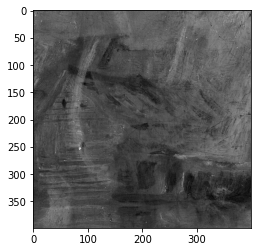

In [271]:
plt.imshow(target, cmap=plt.cm.gray)

In [272]:
input_shape = [None, None, 16]
input_layer = keras.layers.Input(shape=input_shape)
num_layers = 2
filters = 15

layer = input_layer
layer1 = keras.layers.Conv2D(filters=25,
                                kernel_size=3,
                                strides=1,
                                activation='sigmoid',
                                padding='valid')
layer2 = keras.layers.Conv2D(filters=25,
                                kernel_size=1,
                                strides=1,
                                activation='sigmoid',
                                padding='same')
output_layer = keras.layers.Dense(units=1, activation='sigmoid')
model = keras.Sequential([
    input_layer,
    layer1,
    layer2,
    output_layer,]
)

In [273]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, None, None, 25)    3625      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, None, None, 25)    650       
_________________________________________________________________
dense_22 (Dense)             (None, None, None, 1)     26        
Total params: 4,301
Trainable params: 4,301
Non-trainable params: 0
_________________________________________________________________


In [274]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error']
              )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=6,
                                              min_delta=10 ** -5)]
history = model.fit(ins,
                    outs,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks
                    )

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 1s 261us/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 2/10
2000/2000 [==============================] - 0s 74us/sample - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/10
2000/2000 [==============================] - 0s 65us/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0038 - val_mean_squared_error: 0.0038

In [276]:
print(model.predict(inputs).shape)
print(outputs.shape)
# calculate gain and print it out
gain = abs(outputs - model.predict(inputs)) / (outputs.shape[0] * outputs.shape[1])
print('Gain: {:1.4e}'.format(gain.flatten().max()))

(159201, 1, 1, 1)
(159201, 1, 1, 1)
Gain: 3.6701e-06


In [277]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = (target-approx) - np.min(target-approx)
diff = diff/np.max(diff)

imgs = np.concatenate([target, approx, diff], axis=1)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
plt.imshow(diff, cmap=plt.cm.gray)

In [259]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = minMaxScale(target - approx)

imgs = np.concatenate(
    [ np.concatenate([target, approx], axis=1),
    np.concatenate([diff, diff], axis=1)],
    axis=0)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
!dir ../data/

In [244]:
image_path = '../data/raw/still_life/allChannels.mat'
image = sio.loadmat(image_path)['sl']

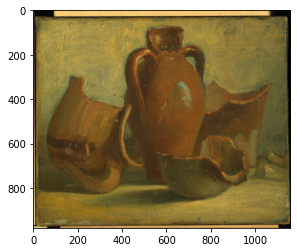

In [253]:
plt.imshow(wavelength2rgb(image[:, :, :16] / 255.0))
plt.imsave('still_life.png',wavelength2rgb(image[:, :, :16] / 255.0))

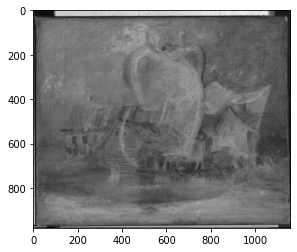

In [257]:
plt.imshow(image[:,:,26], cmap='gray')

In [266]:
plt.imsave('../data/raw/still_life/sample_22_CNN.png',np.squeeze(diff), cmap='gray')